In [1]:
import xgboost as xgb
from xgboost.callback import TrainingCallback
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.base import clone
# import wandb
import matplotlib.pyplot as plt

In [2]:
class CFG:
    n_in = 1
    n_test = 336
    wandb_project_name = 'electricity_demand_forecasting'
    wandb_run_name = 'xgboost'

In [3]:
class WandbCallback(TrainingCallback):
    def __init__(self, period=1):
        self.period = period

    def after_iteration(self, model, epoch, evals_log):
        if epoch % self.period == 0:
            # Assuming 'mae' is being logged. Adjust if a different metric name is used.
            mae = evals_log['train']['mae'][-1]
            # wandb.log({'train-mae': mae})
        return False

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, target_var='TOTALDEMAND'):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.drop(columns=target_var).shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars) if df.columns[j] != target_var]
    
    # Forecast sequence (t+1, ... t+n_out-1), only for predictors, not target
    # Note: We adjust n_out to n_out-1 to make room for the actual target variable at t
    for i in range(1, n_out):
        cols.append(df.drop(columns=target_var).shift(-i))
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars) if df.columns[j] != target_var]

    # Add the target variable column at t (current timestep)
    cols.append(df[[target_var]])
    names.append('%s(t)' % target_var)
    
    # Combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [5]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [6]:
def diy_cv(model, param_grid, splits, trainX, trainy):
    best_score = float("inf")
    best_params = None
    for params in ParameterGrid(param_grid):
        scores = []
        for train_idx, val_idx in splits.split(trainX):
            clone_model = clone(model)
            clone_model.set_params(**params)
            X_train_fold, y_train_fold = trainX.iloc[train_idx], trainy.iloc[train_idx]  # Corrected to use .iloc for trainy
            X_val_fold, y_val_fold = trainX.iloc[val_idx], trainy.iloc[val_idx]  # Corrected to use .iloc for trainy
            clone_model.fit(X_train_fold, y_train_fold)
            predictions = clone_model.predict(X_val_fold)
            score = mean_absolute_error(y_val_fold, predictions)
            scores.append(score)
        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params
        print(f"Params: {params}, Avg MAE: {avg_score}")
    return best_params, best_score

In [7]:
# def log_evaluation(period=1, show_stdv=True):
#     def callback(env):
#         if env.iteration % period == 0:
#             # wandb.log({"Training MAE": env.evaluation_result_list[0][1], "Validation MAE": env.evaluation_result_list[1][1]})
#     return callback

In [8]:
# def wandb_callback():
#     def callback(env):
#         for i, eval_result in enumerate(env.evaluation_result_list):# wandb.log({f"{eval_result[0]}-{eval_result[1]}": eval_result[2]})
#     return callback

In [9]:
CFG = CFG()

In [10]:
config_dict = {
        "n_in": 6,
        "n_test": 30,
        "wandb_project_name": 'electricity_demand_forecasting',
        "wandb_run_name": 'xgboost',
        "param_grid": {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 500, 1000],
        }
    }

In [11]:
# initialize W&B
# wandb.init(
#     project=CFG.wandb_project_name,
#     name=CFG.wandb_run_name,
#     config=config_dict
# )

In [12]:
# load data
df = pd.read_csv('./../data/NSW/final_df.csv', index_col=0)

In [13]:
df

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE,totaldemand_x,rrp,smoothed_FORECASTDEMAND,smoothed_TOTALDEMAND,smoothed_TEMPERATURE,...,normalized_FORECASTDEMAND,normalized_TEMPERATURE,totaldemand_y,dow,doy,year,month,quarter,hour,season
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:30:00,2.009123e+09,36.5,7680.510417,7809.31,22.9,7809.31,21.50,7699.974365,7781.995417,25.233333,...,-0.325943,0.916251,7809.31,4,1,2010,1,1,0,1
2010-01-01 01:00:00,2.009123e+09,37.0,7428.971370,7483.69,22.6,7483.69,20.98,7690.566078,7773.996250,25.266667,...,-0.518995,0.865312,7483.69,4,1,2010,1,1,1,1
2010-01-01 01:30:00,2.009123e+09,37.5,7084.802162,7117.23,22.5,7117.23,20.06,7681.336748,7766.966458,25.302083,...,-0.783139,0.848332,7117.23,4,1,2010,1,1,1,1
2010-01-01 02:00:00,2.009123e+09,38.0,6751.369600,6812.03,22.5,6812.03,17.93,7672.747139,7760.413125,25.335417,...,-1.039043,0.848332,6812.03,4,1,2010,1,1,2,1
2010-01-01 02:30:00,2.009123e+09,38.5,6484.270789,6544.33,22.4,6544.33,17.43,7665.716673,7756.316458,25.366667,...,-1.244036,0.831352,6544.33,4,1,2010,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,2.021032e+09,34.0,7317.702687,7419.77,19.7,7419.77,32.00,7400.366626,7422.855208,19.712500,...,-0.604392,0.372894,7419.77,2,76,2021,3,1,22,2
2021-03-17 22:30:00,2.021032e+09,34.5,7266.887647,7417.91,19.5,7417.91,37.01,7399.723912,7424.357917,19.691667,...,-0.643392,0.338934,7417.91,2,76,2021,3,1,22,2
2021-03-17 23:00:00,2.021032e+09,35.0,7173.866522,7287.32,19.1,7287.32,34.49,7399.132502,7425.781458,19.666667,...,-0.714784,0.271015,7287.32,2,76,2021,3,1,23,2


In [14]:
# prepare data
data = series_to_supervised(df, n_in=CFG.n_in, n_out=1, dropnan=True, target_var='TOTALDEMAND')
data

,PREDISPATCHSEQNO(t-1),PERIODID(t-1),FORECASTDEMAND(t-1),TEMPERATURE(t-1),totaldemand_x(t-1),rrp(t-1),smoothed_FORECASTDEMAND(t-1),smoothed_TOTALDEMAND(t-1),smoothed_TEMPERATURE(t-1),normalized_TOTALDEMAND(t-1),...,normalized_TEMPERATURE(t-1),totaldemand_y(t-1),dow(t-1),doy(t-1),year(t-1),month(t-1),quarter(t-1),hour(t-1),season(t-1),TOTALDEMAND(t)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:00:00,2.009123e+09,36.5,7680.510417,22.9,7809.31,21.50,7699.974365,7781.995417,25.233333,-0.232608,...,0.916251,7809.31,4.0,1.0,2010.0,1.0,1.0,0.0,1.0,7483.69
2010-01-01 01:30:00,2.009123e+09,37.0,7428.971370,22.6,7483.69,20.98,7690.566078,7773.996250,25.266667,-0.483133,...,0.865312,7483.69,4.0,1.0,2010.0,1.0,1.0,1.0,1.0,7117.23
2010-01-01 02:00:00,2.009123e+09,37.5,7084.802162,22.5,7117.23,20.06,7681.336748,7766.966458,25.302083,-0.765079,...,0.848332,7117.23,4.0,1.0,2010.0,1.0,1.0,1.0,1.0,6812.03
2010-01-01 02:30:00,2.009123e+09,38.0,6751.369600,22.5,6812.03,17.93,7672.747139,7760.413125,25.335417,-0.999894,...,0.848332,6812.03,4.0,1.0,2010.0,1.0,1.0,2.0,1.0,6544.33
2010-01-01 03:00:00,2.009123e+09,38.5,6484.270789,22.4,6544.33,17.43,7665.716673,7756.316458,25.366667,-1.205856,...,0.831352,6544.33,4.0,1.0,2010.0,1.0,1.0,2.0,1.0,6377.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,2.021032e+09,33.5,7396.625303,19.7,7503.12,32.41,7400.825986,7421.898125,19.727083,-0.468184,...,0.372894,7503.12,2.0,76.0,2021.0,3.0,1.0,21.0,2.0,7419.77
2021-03-17 22:30:00,2.021032e+09,34.0,7317.702687,19.7,7419.77,32.00,7400.366626,7422.855208,19.712500,-0.532312,...,0.372894,7419.77,2.0,76.0,2021.0,3.0,1.0,22.0,2.0,7417.91
2021-03-17 23:00:00,2.021032e+09,34.5,7266.887647,19.5,7417.91,37.01,7399.723912,7424.357917,19.691667,-0.533743,...,0.338934,7417.91,2.0,76.0,2021.0,3.0,1.0,22.0,2.0,7287.32


In [15]:
# Assuming `data` is your DataFrame after calling series_to_supervised
last_column = data.columns[-1]

if last_column == 'TOTALDEMAND(t)':
    print("The target variable is in the right position.")
else:
    print(f"The target variable is not in the right position, the last column is: {last_column}")

The target variable is in the right position.


In [16]:
n_obs = CFG.n_in * len(df.columns)
n_obs

21

In [17]:
# split into input and outputs, with the last CFG.n_test rows for testing
train, test = train_test_split(data.values, CFG.n_test)
trainX, trainy = train[:, :-1], train[:, -1]
testX, testy = test[:, :-1], test[:, -1]

In [18]:
train

array([[2.00912308e+09, 3.65000000e+01, 7.68051042e+03, ...,
        0.00000000e+00, 1.00000000e+00, 7.48369000e+03],
       [2.00912308e+09, 3.70000000e+01, 7.42897137e+03, ...,
        1.00000000e+00, 1.00000000e+00, 7.11723000e+03],
       [2.00912308e+09, 3.75000000e+01, 7.08480216e+03, ...,
        1.00000000e+00, 1.00000000e+00, 6.81203000e+03],
       ...,
       [2.02103098e+09, 3.45000000e+01, 7.57508441e+03, ...,
        2.20000000e+01, 2.00000000e+00, 7.46171000e+03],
       [2.02103098e+09, 3.50000000e+01, 7.45781667e+03, ...,
        2.30000000e+01, 2.00000000e+00, 7.33309000e+03],
       [2.02103098e+09, 3.55000000e+01, 7.28280971e+03, ...,
        2.30000000e+01, 2.00000000e+00, 7.26008000e+03]])

In [19]:
test

array([[2.02103098e+09, 3.60000000e+01, 7.17448282e+03, ...,
        0.00000000e+00, 2.00000000e+00, 7.04749000e+03],
       [2.02103098e+09, 3.65000000e+01, 7.01718500e+03, ...,
        0.00000000e+00, 2.00000000e+00, 6.82460000e+03],
       [2.02103098e+09, 3.70000000e+01, 6.82562027e+03, ...,
        1.00000000e+00, 2.00000000e+00, 6.53974000e+03],
       ...,
       [2.02103168e+09, 3.45000000e+01, 7.26688765e+03, ...,
        2.20000000e+01, 2.00000000e+00, 7.28732000e+03],
       [2.02103168e+09, 3.50000000e+01, 7.17386652e+03, ...,
        2.30000000e+01, 2.00000000e+00, 7.17239000e+03],
       [2.02103168e+09, 3.55000000e+01, 7.04323686e+03, ...,
        2.30000000e+01, 2.00000000e+00, 7.09451000e+03]])

In [20]:
# further split training into train and validation sets for early stopping
# nominally use the last 10% of the training data as validation
n_val = int(len(trainX) * 0.1)
trainX, valX = trainX[:-n_val], trainX[-n_val:]
trainy, valy = trainy[:-n_val], trainy[-n_val:]

In [21]:
n_val

19425

In [22]:
trainX

array([[2.00912308e+09, 3.65000000e+01, 7.68051042e+03, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.00912308e+09, 3.70000000e+01, 7.42897137e+03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.00912308e+09, 3.75000000e+01, 7.08480216e+03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [2.02001304e+09, 1.70000000e+01, 7.39736636e+03, ...,
        1.00000000e+00, 5.00000000e+00, 1.00000000e+00],
       [2.02001304e+09, 1.75000000e+01, 7.79420529e+03, ...,
        1.00000000e+00, 5.00000000e+00, 1.00000000e+00],
       [2.02001304e+09, 1.80000000e+01, 8.20285686e+03, ...,
        1.00000000e+00, 6.00000000e+00, 1.00000000e+00]])

In [23]:
valX

array([[2.02001304e+09, 1.85000000e+01, 8.62109639e+03, ...,
        1.00000000e+00, 6.00000000e+00, 1.00000000e+00],
       [2.02001304e+09, 1.90000000e+01, 8.96286243e+03, ...,
        1.00000000e+00, 7.00000000e+00, 1.00000000e+00],
       [2.02001305e+09, 1.95000000e+01, 9.16718474e+03, ...,
        1.00000000e+00, 7.00000000e+00, 1.00000000e+00],
       ...,
       [2.02103098e+09, 3.45000000e+01, 7.57508441e+03, ...,
        1.00000000e+00, 2.20000000e+01, 2.00000000e+00],
       [2.02103098e+09, 3.50000000e+01, 7.45781667e+03, ...,
        1.00000000e+00, 2.30000000e+01, 2.00000000e+00],
       [2.02103098e+09, 3.55000000e+01, 7.28280971e+03, ...,
        1.00000000e+00, 2.30000000e+01, 2.00000000e+00]])

In [24]:
trainy

array([7483.69, 7117.23, 6812.03, ..., 7878.78, 8321.65, 8769.52])

In [25]:
valy

array([9072.87, 9396.38, 9493.16, ..., 7461.71, 7333.09, 7260.08])

In [26]:
# Convert the datasets into DMatrix format
dtrain = xgb.DMatrix(trainX, label=trainy)
dval = xgb.DMatrix(valX, label=valy)  # validation set
dtest = xgb.DMatrix(testX)  # test set for final evaluation

In [27]:
dtrain

In [28]:
dval

In [29]:
dtest

In [30]:
# def model parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'objective': 'reg:squarederror',
    'eval_metric': 'mae'
}  # example params, adjust based on best_params if you're using them

In [31]:
# train the model
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    # add validation set in evals if available
    early_stopping_rounds=50,
    callbacks=[WandbCallback()]
)

[0]	train-mae:1029.72506	eval-mae:1085.39801
[1]	train-mae:1019.85347	eval-mae:1075.04486
[2]	train-mae:1010.09096	eval-mae:1064.80605


/home/noone/.cache/pypoetry/virtualenvs/team-0-5QTAbJ9E-py3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [12:58:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	train-mae:1000.43067	eval-mae:1054.68283
[4]	train-mae:990.87508	eval-mae:1044.64166
[5]	train-mae:981.41390	eval-mae:1034.72090
[6]	train-mae:972.03523	eval-mae:1024.86975
[7]	train-mae:962.76339	eval-mae:1015.14279
[8]	train-mae:953.57919	eval-mae:1005.48854
[9]	train-mae:944.49564	eval-mae:995.95146
[10]	train-mae:935.49227	eval-mae:986.48393
[11]	train-mae:926.60645	eval-mae:977.14606
[12]	train-mae:917.80025	eval-mae:967.88623
[13]	train-mae:909.08006	eval-mae:958.70393
[14]	train-mae:900.46437	eval-mae:949.63271
[15]	train-mae:891.92000	eval-mae:940.63748
[16]	train-mae:883.46184	eval-mae:931.73455
[17]	train-mae:875.09748	eval-mae:922.92382
[18]	train-mae:866.82089	eval-mae:914.21108
[19]	train-mae:858.61553	eval-mae:905.57814
[20]	train-mae:850.52038	eval-mae:897.05318
[21]	train-mae:842.49516	eval-mae:888.60375
[22]	train-mae:834.54284	eval-mae:880.23464
[23]	train-mae:826.67289	eval-mae:871.94438
[24]	train-mae:818.88662	eval-mae:863.74480
[25]	train-mae:811.16954	eval-ma

In [32]:
# evaluate the model
yhat = bst.predict(dtest)
error = mean_absolute_error(testy, yhat)

In [33]:
# assuming yhat is the prediction array and testy is the actual target
# values from the test set
actual = testy
predicted = yhat

In [34]:
# generate a time index for plotting.
# since we have 30-minute intervals, this can be represented similarly
# assuming the test set starts immediately after your training and
# val sets, we can calculate the start date as follows
# this requires your original DataFrame (df) to have a datetime index
test_start_date = df.index[-len(testy)]  # get the start date for test set

In [35]:
# generate a date range for the test set
test_dates = pd.date_range(
    start=test_start_date,
    periods=len(testy),
    freq='30min'
)

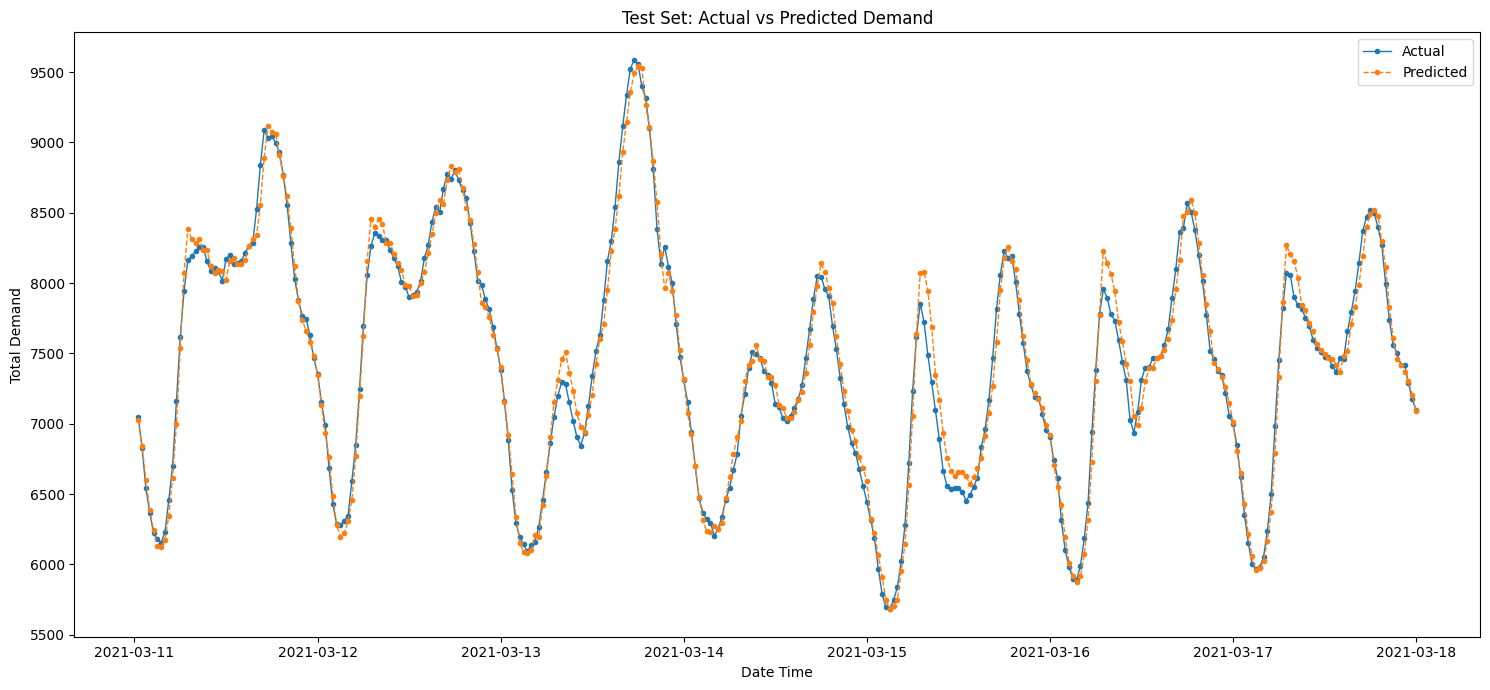

In [36]:
# Plotting
plt.figure(figsize=(15, 7))
plt.plot(test_dates, actual, label='Actual', marker='.', linestyle='-',
             linewidth=1.0)
plt.plot(test_dates, predicted, label='Predicted', marker='.',
             linestyle='--', linewidth=1.0)
plt.title('Test Set: Actual vs Predicted Demand')
plt.xlabel('Date Time')
plt.ylabel('Total Demand')
plt.legend()
plt.tight_layout()

In [37]:
# can focus on a smaller time frame for a more detailed view
# plt.xlim([pd.Timestamp('2010-08-05'), pd.Timestamp('2010-08-12')])

In [38]:
plt.show()

In [39]:
# close the plot to free up memory
plt.close()

In [40]:
# log the test MAE
# wandb.log({"Test MAE": error})

In [41]:
# finish the W&B run
# wandb.finish()